<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/batchnorm_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We implement a batchnorm layer from scratch and add to LeNet CNN.

based on sec 7.5 of http://d2l.ai/chapter_convolutional-modern/batch-norm.html




In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

mkdir: cannot create directory ‘figures’: File exists


# Implementation from scratch

For fully connected layers, we take the average along minibatch samples for each dimension independently. For 2d convolutional layers, we take the average along minibatch samples, and along horizontal and vertical locations, for each channel (feature dimension) independently.

When training, we update the estimate of the mean and variance using a moving average. When testing (doing inference), we use the pre-computed values.

In [2]:


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

# Wrap the batch norm function in a layer

In [3]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

# Applying batch norm to LeNet

We add BN layers after some of the convolutions and fully connected layers,
but before the activation functions.

In [4]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

# Train the model

We train the model using the same code as in the [standard LeNet colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lenet_torch.ipynb).  In the d2l book, this is called [train_ch6](https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py#L470). The only difference from the previous colab is the larger learning rate (which is possible because BN stabilizes training).

loss 0.248, train acc 0.908, test acc 0.883
20903.9 examples/sec on cuda:0


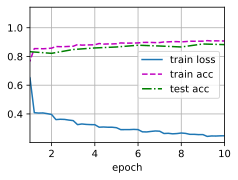

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())